# 2. Sampling

Sampling is traditionally performed by an analogue to digital converter (ADC). The process can be thought of as recording the voltage level of an analogue signal at an instant in time. This sample is assigned a binary number through a process called quantisation - more on that later. By collecting samples at a regular period, we can approximate an analogue signal on a digital system.

<img src="./images/ADC.png" style="width: 650px;"/>

The speed at which an ADC generates binary numbers is called the **sampling rate** or **sampling frequency**, $f_{s}$.

The time between samples is called the **sampling period**, $t_{s}$:

$ t_{s} = 1 / f_{s} $

Sampling frequency is quoted in samples per second, or simply as Hertz (Hz).

The actual sampling rate will depend on parameters of the application.
This may vary from:  
**10’s** of Hz for control systems,  
**100’s** of Hz for biomedical,  
**1000’s** of Hz for audio applications,  
**1,000,000’s** of Hz for IF digital radios,  
**1,000,000,000's** of Hz for RF digital radios.  

### Import Libraries

In [3]:
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
import scipy.fftpack
import helper_functions as hf

This notebook is written for and runs on a digital system and therefore we cannot truthfully generate a continuous analogue signal. However, for the purposes of this notebook, we can approximate one by sampling it at a high rate. 

In the following cell we will create a "continuous" sine wave of frequency 100 Hz. The formula for generating a sine wave is:

$ y(t) = Asin(2\pi ft + \phi) $

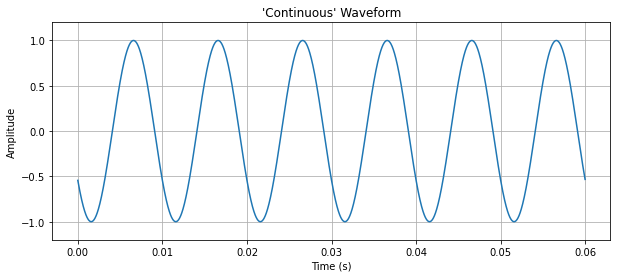

In [4]:
A = 1       # Amplitude
f = 100     # Desired frequency 
t = 0.06    # Time
p = 10      # Phase

ar = 48000  # A high sample rate to approximate a continuous signal. ar = analogue rate

x_cont = np.arange(0, t, 1/ar)                    # Discrete time i.e. sampled time period
y_cont = A * np.sin(2 * np.pi * f * x_cont + p)   # Formula for sine wave

ax = hf.plot_timeseries("'Continuous' Waveform",
                        [x_cont], [y_cont],
                        ['continuous'])

## 2.1 Sampling - How Fast?

In order to ensure that we retain **all** of the information in the signal, what **sampling rate** should be used? 

<img src="./images/sampler.png" style="width: 650px;"/>

Below, we will sample the "continuous" 100 Hz signal at various sample rates and inspect the results.

Sampling at $f_{s}$=100 Hz, i.e. 1 sample per period:

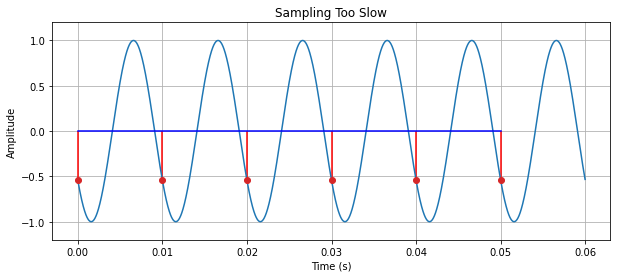

In [5]:
A = 1       # Amplitude
f = 100     # Desired frequency 
t = 0.06    # Time
p = 10      # Phase

fs = 100    # 100 Hz (1 sample per period)

x = np.arange(0, t, 1/fs)                # Discrete time i.e. sampled time period
y = A * np.sin(2 * np.pi * f * x + p)    # Formula for sine wave

hf.plot_timeseries("Sampling Too Slow",
                   [x_cont, x], [y_cont, y], 
                   ['continuous', 'discrete'])

The signal here is interpreted as DC with an offset of -0.54 V. 

Sampling at $f_{s}$=80 Hz, i.e. 1 sample every 0.8 of a period:

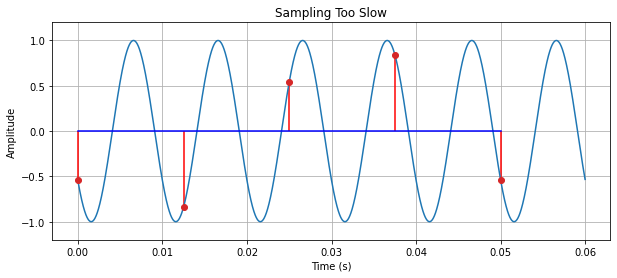

In [6]:
A = 1       # Amplitude
f = 100     # Desired frequency 
t = 0.06    # Time
p = 10      # Phase

fs = 80    # 80 Hz (1 sample every 0.8 of a period)

x = np.arange(0, t, 1/fs)                # Discrete time i.e. sampled time period
y = A * np.sin(2 * np.pi * f * x + p)    # Formula for sine wave

hf.plot_timeseries("Sampling Too Slow",
                   [x_cont, x], [y_cont, y],
                   ['continuous', 'discrete'])

Most of the signal features here are "missed". In both of these instances, the sampling rate is too slow to record enough of the signal's information to accurately reconstruct. It can be observed in instances where the sampling rate is too low that the signal is interpreted as having a slower frequency. 

Sampling at $f_{s}$=800 Hz, i.e. 8 samples per period:

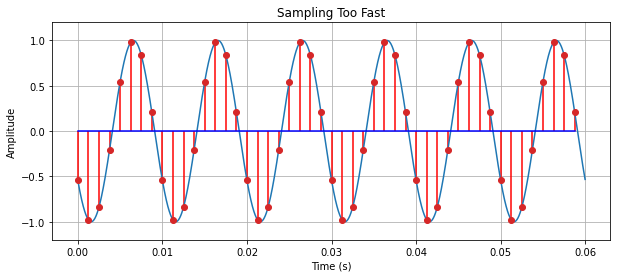

In [7]:
A = 1       # Amplitude
f = 100     # Desired frequency 
t = 0.06    # Time
p = 10      # Phase

fs = 800    # 800 Hz (8 samples per period)

x = np.arange(0, t, 1/fs)                # Discrete time i.e. sampled time period
y = A * np.sin(2 * np.pi * f * x + p)    # Formula for sine wave

hf.plot_timeseries("Sampling Too Fast", 
                   [x_cont, x], [y_cont, y], 
                   ['continuous', 'discrete'])

This appears to be a "reasonable" sample rate. 

Sampling at $f_{s}$=3000 Hz, i.e. 30 samples per period:

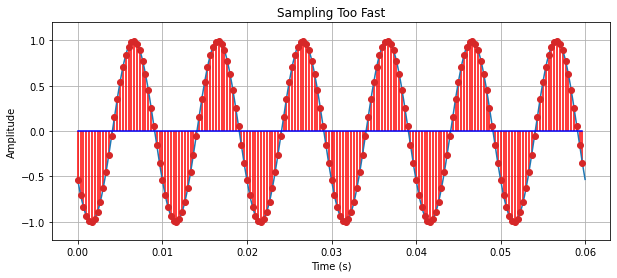

In [8]:
A = 1       # Amplitude
f = 100     # Desired frequency 
t = 0.06    # Time
p = 10      # Phase

fs = 3000    # 3000 Hz (30 samples per period)

x = np.arange(0, t, 1/fs)                # Discrete time i.e. sampled time period
y = A * np.sin(2 * np.pi * f * x + p)    # Formula for sine wave

hf.plot_timeseries("Sampling Too Fast", 
                   [x_cont, x], [y_cont, y], 
                   ['continuous', 'discrete'])

Perhaps this rate is higher than necessary.

Sampling too high will better approximate the original signal, however more samples will require more processing. So what is a "suitable" sampling rate? 

## 2.2 Sampling Theorem

From mathematical theory, the minimum sampling rate required to retain all information is referred to as the **Nyquist frequency/rate**:

$f_{n}\ge 2 \times f_{max} $

where $f_{max}$ is the maximum frequency component of a **baseband**, **bandlimited** signal.

**Baseband:** The lowest signal frequency present is around 0 Hz:
<img src="./images/baseband.png" style="width: 600px; vertical-align: middle;"/>

**Bandlimited:** For all frequencies in the signal $f_{l}<f<f_h$:
<img src="./images/bandlimited.png" style="width: 600px; vertical-align: middle;"/>

## 2.3 Aliasing
When a (baseband) signal is sampled at a frequency below the Nyquist rate, then we “lose” the signal frequency information and aliasing is said to have occurred. 

Aliasing can be illustrated by sampling a sine wave at below the Nyquist rate and then “reconstructing”. We note that it appears as a sine wave of a lower frequency (aliasing - cf. impersonating).

Consider again sampling the 100 Hz size wave at 80 Hz: 

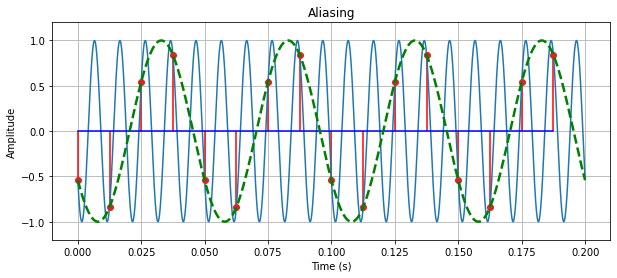

Perceived frequency:  20.0 Hz


In [9]:
A = 1       # Amplitude
f = 100     # Desired frequency 
t = 0.2     # Time
p = 10      # Phase

fs = 80     # Sampling frequency 
 
# 'Continuous' waveform
x_cont = np.arange(0, t, 1/ar)                   
y_cont = A * np.sin(2 * np.pi * f * x_cont + p)   

# Sampled waveform
x = np.arange(0, t, 1/fs)               
y = A * np.sin(2 * np.pi * f * x + p)   

# Perceived aliased waveform
f_alias = f-fs*np.round(f/fs)
x_alias = np.arange(0, t, 1/ar)
y_alias = A * np.sin(2 * np.pi * f_alias * x_alias + p)

hf.plot_timeseries("Aliasing",
                   [x_cont, x, x_alias], [y_cont, y, y_alias],
                   ['continuous', 'discrete', 'dash'])
print("Perceived frequency: ", f_alias, "Hz")

Observe that when the sampling rate does not obey the sampling theorem stated above, the perceived waveform is of a lower frequency. In the case of a desired frequency of 100 Hz and a sampling rate of 80 Hz, the perceived signal has a frequency of $f_{s}-f_{signal} = 20 Hz$.

Try changing the sampling rate and/or desired frequency and observe the effects on the perceived waveform.

## 2.4 Reconstructing an Analogue Signal
We can see how various sampling rates are interpreted by recontucting the sampled signal. Reconstruction is performed when converting a signal from the digital domain into analogue. A digital to analogue converter (DAC) will hold the voltage value for a period of $ t_s$ for each of the samples giving a "steppy" signal. 

<img src="./images/DAC.png" style="width: 650px;"/>

## 2.5 Zero Order Hold
To model the signal reconstruction performed by a DAC, we can apply a zero order hold (ZOH) to the digital signal. The function below acheives this, given an input signal and a sampling frequency. 

The zero order hold function below first makes the signal "continuous" by zero padding the array to a rate of 48000 Hz - the rate we use to approximate an analogue signal in this notebook. This padded signal is then convolved with the impulse response of ZOH, which is a rectangular window of length, $ t_s $. 

In [10]:
def zero_order_hold(signal, fs):
    # New time axis for 'continuous' signal
    x_zoh = np.arange(0, len(signal)/fs, 1/48000)
    
    # Zero pad the original signal to new rate
    y_zoh = np.zeros(len(x_zoh))
    y_zoh_indices = y_zoh[::int(np.round(48000/fs))]
    y_zoh_indices[0:len(signal)] = signal
    y_zoh[::int(np.round(48000/fs))] = y_zoh_indices
    
    # Create ZOH impulse response and convolve with input signal
    h_zoh = np.ones(int(48000/fs))
    y_zoh = np.convolve(h_zoh,y_zoh)
    
    # Chop of end to match time axis length
    y_zoh = y_zoh[0:len(x_zoh)] 
    
    return x_zoh, y_zoh

Try changing the sampling rate to see the different outputs from the ZOH.

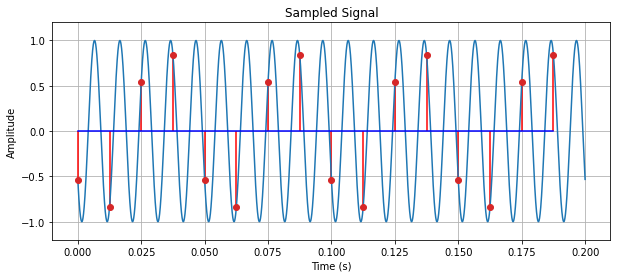

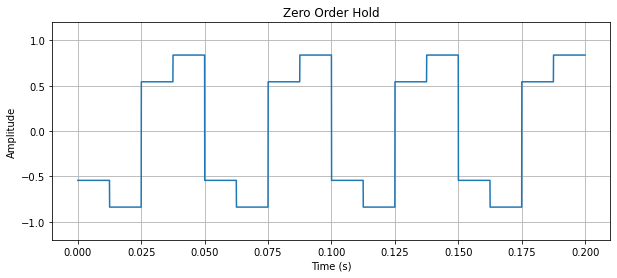

In [13]:
A = 1       # Amplitude
f = 100     # Desired frequency 
t = 0.2    # Time
fs = 80    # Sampling rate

# Define 'continuous' signal for comparison
x_cont = np.arange(0, t, 1/48000)            
y_cont = A * np.sin(2 * np.pi * f * x_cont + 10)  

# Sampled signal
x = np.arange(0, t, 1/fs)                # Discrete time i.e. sampled time period
y = A * np.sin(2 * np.pi * f * x + 10)   # Formula for sine wave

hf.plot_timeseries("Sampled Signal",
                   [x_cont, x], [y_cont, y], 
                   ['continuous','discrete'])

# Perform ZOH on sampled signal
[x_zoh, y_zoh] = zero_order_hold(y, fs)
ax = hf.plot_timeseries("Zero Order Hold", 
                        [x_zoh], [y_zoh], 
                        ['continuous'])

Note that the output is a little “steppy” caused by the zero order hold (step reconstruction). This artefact can however be removed with a **reconstruction filter**.

A reconstruction filter is implemented after the DAC with analogue circuitry. It removes the baseband image high frequencies present in the signal (in the form of the steps between the discrete levels).

Ideally reconstruction filters have very sharp cut off filters at frequency $f_{s}/2$. Steeper roll-off is more expensive, but clearly for many applications, good analogue filters are essential.

In a DSP system the accurately trimmed analogue filters could actually be more costly than the other DSP components, and their accuracy can be affacted by temperature, ageing, etc. Therefore, it is desirable to do as much as possible of the filtering digitally.

To this end, we will first **interpolate** the sampled signal digitally before passing into our "analogue" reconstruction filter. 

The processes of interpolation is simply **upsampling** a signal followed by a **lowpass anti-imaging filter**. 

<img src="./images/upsample_3.png" style="width: 750px;"/>

In [14]:
def generate_lowpass(fs, cutoff, stop, numtaps):
    taps = signal.remez(numtaps, [0, cutoff, stop, 0.5*fs], [1, 0], Hz=fs)
    w, h = signal.freqz(taps, [1], worN=2000)
    return w, h, taps

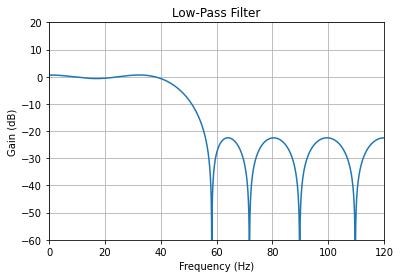

In [15]:
R = 3
Fs = fs*R
w, h, coeffs = generate_lowpass(Fs, fs/2, 1.4*(fs/2), 15)
hf.plot_response(Fs, w, h, title = "Low-Pass Filter")

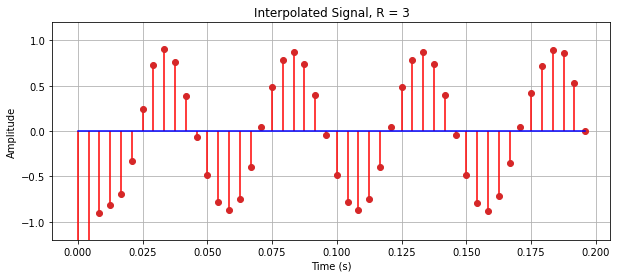

In [16]:
x_ov = np.arange(0, t, 1/(Fs))
y_ov = np.zeros(len(y)*R)
y_ov[::R] = y

y_lp = signal.filtfilt(coeffs, 1, y_ov) * R
hf.plot_timeseries("Interpolated Signal, R = 3",
                   [x_ov], [y_lp],
                  ['discrete'])

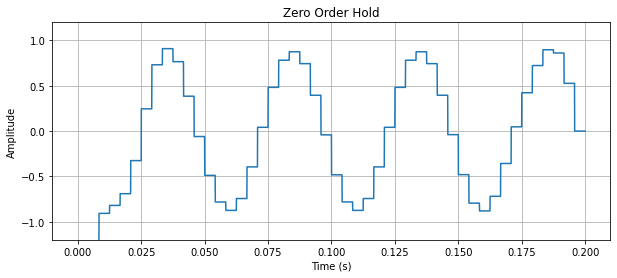

In [17]:
# Perform ZOH on sampled signal
[x_zoh, y_zoh] = zero_order_hold(y_lp, Fs)
hf.plot_timeseries("Zero Order Hold",
                   [x_zoh], [y_zoh],
                   ['continuous'])

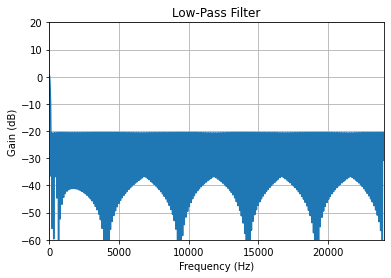

In [18]:
w, h, coeffs = generate_lowpass(48000, fs/2, Fs/2, 400)
hf.plot_response(48000, w, h, title = "Low-Pass Filter")

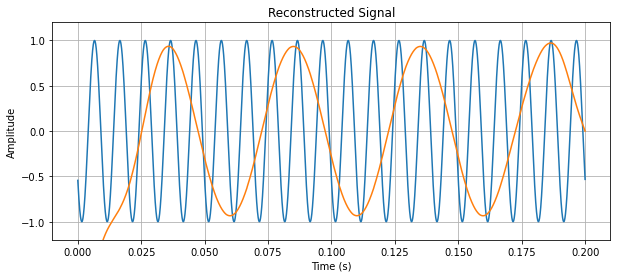

In [22]:
# [x_zoh, y_zoh] = zero_order_hold(y, fs)
y_recon = signal.filtfilt(coeffs, 1, y_zoh)
hf.plot_timeseries("Reconstructed Signal",
                   [x_cont, x_zoh], [y_cont, y_recon],
                   ['continuous','continuous'])

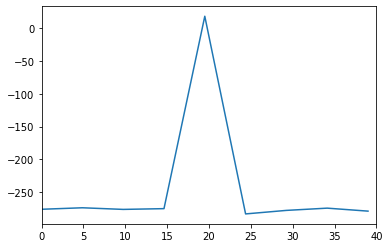

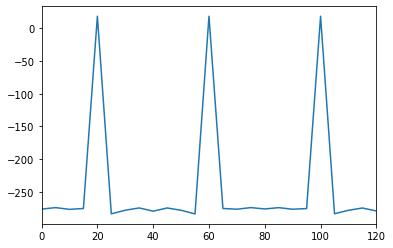

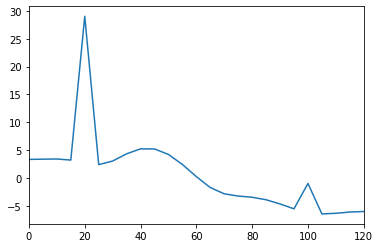

<ipython-input-23-dfe93b265576>:6: RuntimeWarning: divide by zero encountered in log10
  db = 10 * np.where(mag>0, np.log10(mag), 0)


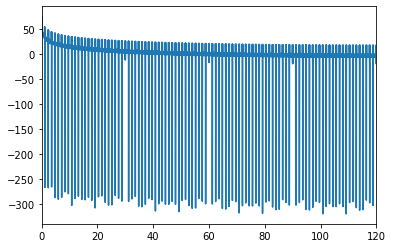

In [191]:
fft(y,fs)
fft(y_ov, Fs)
fft(y_lp,Fs)
fft(y_zoh,Fs)

In [23]:
def fft(y, fs):
    N = len(y) + 2
    T = 1.0 / fs
    yf = np.fft.rfft(y)
    mag = abs(yf**2)
    db = 10 * np.where(mag>0, np.log10(mag), 0)
    xf = np.linspace(0.0, 1.0//(2.0*T), N//2)
    fig, ax = plt.subplots()
    ax.plot(xf, db)
    ax.set_xlim(0,fs/2)
    plt.show()

[⬅️ Previous](01_introduction.ipynb) [👩‍💻](01_introduction.ipynb) [Next ➡️](03_quantisation.ipynb)